# Validation test FLEXI
 

In [59]:
###########################################################################################################
# OBJECTIVE: Use SCPI with Python to connect to several instruments to perform the validation tests on a
# 4-switch buck-boost for the FLEXI project. 
# Input voltage range: 80-150
# Output voltage: 100 V
# Output current: 5 A
# switching frequency: 100kHz
#  
# sensors: Voltage (In-Out), Current (In-Out), Inductor current
###########################################################################################################

##  1.0 Initialization

In [2]:
import pyvisa
import time
import numpy as np
import pandas as pd
import sys

ExitMode=['exit','Exit','EXIT']
rm = pyvisa.ResourceManager()
resources=rm.list_resources()
instruments = np.array(resources)
print(resources)
devices = []
for resource in resources:
    try:
        instrument = rm.open_resource(resource)
        print(f'{resource} is available')
        address = instrument.resource_name
        vendor = instrument.query("*IDN?").strip()
        devices.append([address, vendor, 'Available'])
        identity = instrument.query('*IDN?')
#        print(identity)
        instrument.close()
    except:
        print(f'{resource} is not available')
        devices.append([resource,"","Not available"])

def classify_vendor(vendor):
    if 'MSO7034B' in vendor:
        return 'Oscilloscope'
    elif '34461' in vendor:
        return 'DMM'
    elif 'N3300' in vendor:
        return 'Load'
    elif 'AC6803' in vendor:
        return 'Input'
    else:
        return 'Other'
devices_df = pd.DataFrame(devices, columns=['Address', 'Vendor','Available?'])
devices_df['Function'] = devices_df['Vendor'].apply(classify_vendor)
dmm_mask = devices_df['Function'] == 'DMM'
other_mask = devices_df['Function'] != 'DMM'
dmm_addresses = (devices_df['Function'] == 'DMM') & (~devices_df['Address'].str.contains('MY57224092|MY57224113|MY57224258|MY57224696'))                                
devices_df['Measure'] = np.where(dmm_mask & devices_df['Address'].str.contains('MY57224092'), 'Vin', 
                                np.where(dmm_mask & devices_df['Address'].str.contains('MY57224113'), 'Iin', 
                                         np.where(dmm_mask & devices_df['Address'].str.contains('MY57224258'), 'Vout',
                                                  np.where(dmm_mask & devices_df['Address'].str.contains('MY57224696'), 'Iout',np.nan))))







DMM_sequence=['Vinmeas','Iinmeas','Voutmeas','Ioutmeas','Pin','Pout','Eff']
Oscil_sequence=['Vin','VinAC','Vout','VoutAC','Iload','IloadAC','Iin','IinAC','Iout','IoutAC','VinSens','IinSens','VoutSens','IoutSens','IloadSens','IloadSensRip']
Test_sequence=Oscil_sequence
# Test_sequence=['Vinput','Vinput AC','Voutput','Voutput AC','Iload','Iload AC','Iinput','Iinput AC','Ioutput','Ioutput AC','Vinput sens','Iinput sens','Voutput sens','Ioutput sens','Iload sens','Iload sens rip']
rows=['PNG name','CSV name']
# Create a DataFrame with the columns defined by Test_sequence
df = pd.DataFrame(columns=Test_sequence,index=rows)
ChanNum=4
Oscil_Address= devices_df.loc[devices_df['Function'] == 'Oscilloscope', 'Address'].values[0]
VinDMM_Address = devices_df.loc[(devices_df['Function'] == 'DMM')& (devices_df['Measure'] == 'Vin'), 'Address'].values[0]
VoutDMM_Address = devices_df.loc[(devices_df['Function'] == 'DMM')& (devices_df['Measure'] == 'Vout'), 'Address'].values[0]
Load_Address = devices_df.loc[devices_df['Function'] == 'Load', 'Address'].values[0]
IinDMM_Address = devices_df.loc[(devices_df['Function'] == 'DMM')& (devices_df['Measure'] == 'Iin'), 'Address'].values[0]
IoutDMM_Address = devices_df.loc[(devices_df['Function'] == 'DMM')& (devices_df['Measure'] == 'Iout'), 'Address'].values[0]
Vin_Address = devices_df.loc[devices_df['Function'] == 'Input', 'Address'].values[0]
# Test_sequence = DMM_sequence+Oscil_sequence
# Test_sequence=Oscil_sequence
LoadCurr=['1','5'] # A
LoadCurr=[input('Choose load current (1 to 5 (amps))')]

ConvMode=['Buck','Boost']
ConvMode=[input('Choose converter (either Buck or Boost). NOTE: write Buck  or Boost. BuckBoost ode not implemented yet')]
prototype=input('choose prototype number.')

ConvModeVoltageDict={'Buck':'150','Boost':'80'}
files=['CSV', 'PNG']
MeasOsc={'Frequency':'FREQuency','Average':'VAVerage','Pk to pk':'VPP'}
MeasOscQuery={}
for measquery in Oscil_sequence:
    if measquery in ['Vout','Vin','Iin','Iout','Iload']:
        MeasOscQuery[measquery]='VAVerage'
    elif measquery in ['VinAC','VoutAC','IinAC','IoutAC','IloadAC','IloadSensRip']:
        MeasOscQuery[measquery]='VPP'
    elif measquery in ['VinSens','VoutSens','IinSens','IoutSens','IloadSens']:
        MeasOscQuery[measquery]='VAVerage'



ChanMeasOsc={}
for measu in Oscil_sequence:
    if measu in ['Vout','Vin','VinAC','VoutAC']:
        ChanMeasOsc[measu]='1'
    elif measu in ['Iin','Iout','Iload','IinAC','IoutAC','IloadAC']:
        ChanMeasOsc[measu]='3'
    elif measu in ['VinSens','VoutSens','IinSens','IoutSens','IloadSens','IloadSensRip']:
        ChanMeasOsc[measu]='2'



ChanConfLevel = {}
for item in Oscil_sequence:
    if item in ['Iin', 'Iout','IinSens','IoutSens']:
        ChanConfLevel[item] = ['5', '500mV', '1', '2']
    if item in ['VoutSens','VinSens']:
        ChanConfLevel[item] = ['50', '500mV', '1', '2']
    elif item in ['Iload']:
        ChanConfLevel[item] = ['5', '500mV', '1', '2']
    elif item in ['Vin', 'Vout']:
        ChanConfLevel[item] = ['50', '500mV', '1', '2']
    elif item in ['VinAC', 'VoutAC']:
        ChanConfLevel[item] = ['200mV', '500mV', '1', '2']
    elif item in ['IinAC', 'IoutAC']:
        ChanConfLevel[item] = ['5', '500mV', '1', '0.5']
    elif item in ['IloadAC']:
        ChanConfLevel[item] = ['5', '500mV', '1', '2']    
    elif item in ['IloadSens']:
        ChanConfLevel[item] = ['50mV', '500mV', '1', '2']
    elif item in ['IloadSensRip']:
        ChanConfLevel[item] = ['50mV', '50mV', '1', '2']
    else:
        ChanConfLevel[item] = ['5', '500mV', '1', '2']

OffsetConf={}
for item in Oscil_sequence:
    for val in LoadCurr:
        if item in ['Iin', 'Iout','VinSens','IinSens','VoutSens','IoutSens']:
            OffsetConf[val,item] = ['0', '1.4', '3.8', '2']
        elif item in ['Vin', 'Vout']:
            OffsetConf[val,item] = ['50', '1.4', '3.8', '2']
        elif item in ['VinAC', 'VoutAC']:
            OffsetConf[val,item] = ['0', '-500mV', '3.8', '2']
        elif item in ['IinAC', 'IoutAC']:
            OffsetConf[val,item] = ['0', '-500mV', '3.8', '0.5']
        elif item in ['IloadSens']:
            OffsetConf[val,item] = ['50mV', '1.4', '3.8', '2']
        elif item in ['IloadAC']:
            OffsetConf[val,item] = ['50mV', '1.4', '2', '2']
        elif item in ['Iload']:
            OffsetConf[val,item]=['0','1.5','3.8','2']
        elif item in ['IloadSensRip']:
            if val in ['1']: # if output current is 1 A
                OffsetConf[val,item] = ['0', '2.45', '1', '2']
            else: # if output current is 5 A
                OffsetConf[val,item] = ['0', '2.65', '1', '2']
        else:
            OffsetConf[val,item] = ['5', '-500mV', '3.8', '2']

OnOffConf={}
for item in Oscil_sequence:
    if item in ['Vin', 'Vout', 'VinAC', 'VoutAC']:
        OnOffConf[item]=['ON','OFF','ON','OFF']
    elif item in ['IinAC','Iin', 'Iout', 'IoutAC']:
        OnOffConf[item]=['OFF','OFF','ON','ON']
    elif item in ['Iload','IloadAC']:
        OnOffConf[item]=['OFF','OFF','ON','OFF']
    elif item in ['VinSens','VoutSens']:     
        OnOffConf[item]=['OFF','ON','ON','OFF']     
    elif item in ['IinSens','IoutSens']:     
        OnOffConf[item]=['OFF','ON','ON','OFF'] 
    elif item in ['IloadSens','IloadSensRip']:
        OnOffConf[item] = ['OFF','ON','ON','OFF']

ACDCConf= {}
for item in Oscil_sequence:
    if item in ['VinAC', 'VoutAC']:
        ACDCConf[item]=['AC','DC','DC','DC']
    elif item in ['IinAC', 'IoutAC']:
        ACDCConf[item]=['DC','DC','DC','AC']
    elif item in ['IloadSens']:
        ACDCConf[item]=['AC','DC','DC','DC']
    elif item in ['IloadAC']:
        ACDCConf[item]=['AC','DC','AC','DC']
    elif item in ['Iload']:
        ACDCConf[item]=['DC','DC','DC','DC']
    elif item in ['IloadSensRip']:
        ACDCConf[item]=['DC','DC','DC','DC']
    else:
        ACDCConf[item]=['DC','DC','DC','DC']

TrigConf={}
for item in Oscil_sequence:
    for val in LoadCurr:
        for conv in ConvMode:
            if conv in ['Buck']:
                if item in ['IloadAC']:
                    TrigConf[conv,val,item]='0'
                else:
                    TrigConf[conv,val,item]=str(float(val))

            else:#BOOST mode
                if item in ['IloadAC']:
                    TrigConf[conv,val,item]='0'
                else:
                    TrigConf[conv,val,item]=str(float(val)*1.3)



multiindex = pd.MultiIndex.from_product([ConvMode, LoadCurr], names=["ConvMode", "LoadCurr"])
df = pd.DataFrame(index=multiindex, columns=pd.MultiIndex.from_product([Oscil_sequence, files], names=["Measurement", "Files"]))

DMM_df=pd.DataFrame(index=multiindex, columns=pd.MultiIndex.from_product([DMM_sequence], names=["Measurement"]))

Meas_df=pd.DataFrame(index=multiindex, columns=pd.MultiIndex.from_product([Oscil_sequence,MeasOsc], names=["Measurement","Inductor current meas"]))



OutLoad = rm.open_resource(Load_Address)
Vin = rm.open_resource(Vin_Address)
Oscil=rm.open_resource(Oscil_Address)
VinDMM = rm.open_resource(VinDMM_Address)
IoutDMM = rm.open_resource(IoutDMM_Address)
VinDMM = rm.open_resource(VinDMM_Address)
IinDMM = rm.open_resource(IinDMM_Address)
VoutDMM = rm.open_resource(VoutDMM_Address) 


VoutDMM.write('DISP:TEXT "Vout Meas"')
IoutDMM.write('DISP:TEXT "Iout Meas"')

VinDMM.write('DISP:TEXT "Vin Meas"')

IinDMM.write('DISP:TEXT "Iin Meas"')


('ASRL5::INSTR', 'USB0::0x0957::0x173D::MY50340340::0::INSTR', 'USB0::0x0957::0xAC07::JPWC002359::0::INSTR', 'USB0::0x2A8D::0x1301::MY57224092::0::INSTR', 'USB0::0x2A8D::0x1301::MY57224113::0::INSTR', 'USB0::0x2A8D::0x1301::MY57224258::0::INSTR', 'USB0::0x2A8D::0x1301::MY57224696::0::INSTR', 'USB0::0x2A8D::0x1401::MY57224092::0::INSTR', 'USB0::0x2A8D::0x1401::MY57224113::0::INSTR', 'USB0::0x2A8D::0x1401::MY57224258::0::INSTR', 'USB0::0x2A8D::0x1401::MY57224696::0::INSTR')
ASRL5::INSTR is available
USB0::0x0957::0x173D::MY50340340::0::INSTR is available
USB0::0x0957::0xAC07::JPWC002359::0::INSTR is available
USB0::0x2A8D::0x1301::MY57224092::0::INSTR is available
USB0::0x2A8D::0x1301::MY57224113::0::INSTR is available
USB0::0x2A8D::0x1301::MY57224258::0::INSTR is available
USB0::0x2A8D::0x1301::MY57224696::0::INSTR is available
USB0::0x2A8D::0x1401::MY57224092::0::INSTR is not available
USB0::0x2A8D::0x1401::MY57224113::0::INSTR is not available
USB0::0x2A8D::0x1401::MY57224258::0::INST

22

In [2]:
devices_df

,Address,Vendor,Available?,Function,Measure
0,ASRL5::INSTR,"Agilent Technologies,N3300A,0,A.00.08",Available,Load,nan
1,USB0::0x0957::0x173D::MY50340340::0::INSTR,"AGILENT TECHNOLOGIES,MSO7034B,MY50340340,06.15...",Available,Oscilloscope,nan
2,USB0::0x0957::0xAC07::JPWC002359::0::INSTR,"Agilent,AC6803A,JPWC002359,A.01.02.0088",Available,Input,nan
3,USB0::0x2A8D::0x1301::MY57224092::0::INSTR,"Keysight Technologies,34461A,MY57224092,A.02.1...",Available,DMM,Vin
4,USB0::0x2A8D::0x1301::MY57224113::0::INSTR,"Keysight Technologies,34461A,MY57224113,A.02.1...",Available,DMM,Iin
5,USB0::0x2A8D::0x1301::MY57224258::0::INSTR,"Keysight Technologies,34461A,MY57224258,A.02.1...",Available,DMM,Vout
6,USB0::0x2A8D::0x1301::MY57224696::0::INSTR,"Keysight Technologies,34461A,MY57224696,A.02.1...",Available,DMM,Iout
7,USB0::0x2A8D::0x1401::MY57224092::0::INSTR,,Not available,Other,nan
8,USB0::0x2A8D::0x1401::MY57224113::0::INSTR,,Not available,Other,nan
9,USB0::0x2A8D::0x1401::MY57224258::0::INSTR,,Not available,Other,nan


## 2.A Oscilloscope test sequence

In [7]:
###PRECONFIGURE LOAD????


OutLoad.write("*RST")
OutLoad.write("INP ON")
OutLoad.write("CHANnel 2")
OutLoad.write("FUNC CURR")
OutLoad.write("CURR 1")


for converter in ConvMode: #choose either buck or boost
###############--CONFIGURE INPUT--############################
    print('Configuring Input')

    Vin.write("*RST") #Reset to default settings
    Vin.write("OUTP:COUPLing DC")
    Vin.write("SOUR:VOLT:OFFS {}".format(ConvModeVoltageDict[converter]))
    Vin.write("SOUR:VOLTage:RANGE AUTO")
    Vin.write("SOUR:CURRent:OFFSET 8")

    for load_current in LoadCurr: # choose current
        print('Configuring Load')
        if input('Testing in {} mode at {} A. Press ENTER to continue or EXIT to cancel'.format(converter,load_current)) in ExitMode :
            sys.exit()

###############--CONFIGURE LOAD--############################
        OutLoad.write("INP ON")
        OutLoad.write("CHANnel 2") # Load channel we are using
        OutLoad.write("FUNC CURR")
        OutLoad.write("CURR {}".format(str(load_current[0])))
        Vin.write("OUTP 1") #Enable Vin source output AFTER configuring load (safety purposes)
        
        vinmeas = Vin.query_ascii_values("MEAS:VOLT?")
        iinmeas = Vin.query_ascii_values("MEAS:CURR?")
        print("Input voltage is {}. Current consumption is {}.".format(vinmeas[0],iinmeas[0]))



###############--VERY IMPORTANT: START FPGA--##############
        if input('START TURN ON SEQUENCE ON FPGA (switches). Verify it works. Press ENTER TO CONTINUE if all OK') in ExitMode:
            sys.exit()
        GoOn=input('All OK? Should we start measuring? Press "y" to start')
        if GoOn in ExitMode:
            sys.exit()
        else: 
            while GoOn!='y':
                if GoOn in ExitMode:
                    sys.exit()
                else:
                    GoOn=input('All OK? Should we start measuring? Press "y" to start')
        Vin.write("OUTP 1") #Enable Vin source output AFTER configuring load (safety purposes)    
        


# ###############--CONFIGURE DMM--#############################                
    # Configure Vin DMM
        try:    
            VinDMM = rm.open_resource(VinDMM_Address)
            VinDMM.write("*RST")
            VinDMM.write("*CLS")
            VinDMM.write("CONF:VOLT:DC AUTO")
            VinDMM.write("TRIG:DEL:AUTO ON")
            VinDMM.query("*OPC?")
            Vinrcv=VinDMM.query("READ?")
            print('Vin: '+ Vinrcv)
            DMM_df.loc[(converter,load_current),'Vinmeas']=float(Vinrcv.replace('\n',''))
            VinDMM.write('DISP:TEXT:CLE')

            
        except:
            print('Vin DMM not available')

        # Configure Iin DMM
        try:
            IinDMM = rm.open_resource(IinDMM_Address)
            IinDMM.write("*RST")
            IinDMM.write("*CLS")
            IinDMM.write("CONF:CURR:DC AUTO")
            IinDMM.write("CURR:DC:TERMinals 10")
            IinDMM.write("TRIG:DEL:AUTO ON")
        
            IinDMM.query("*OPC?")
            Iinrcv=IinDMM.query("READ?")
            print('Iin: '+Iinrcv)
            DMM_df.loc[(converter,load_current),'Iinmeas']=float(Iinrcv.replace('\n',''))
            IinDMM.write('DISP:TEXT:CLE')
        except:
            print('Iin DMM not available')

        # Configure Vout DMM
        try:
            VoutDMM = rm.open_resource(VoutDMM_Address) 
            VoutDMM.write("*RST")
            VoutDMM.write("*CLS")
            VoutDMM.write("CONF:VOLT:DC AUTO")
            VoutDMM.write("TRIG:DEL:AUTO ON")
            VoutDMM.query("*OPC?")
            Voutrcv=VoutDMM.query("READ?")
            print('Vout: '+Voutrcv)
            DMM_df.loc[(converter,load_current),'Voutmeas']=float(Voutrcv.replace('\n',''))
            VoutDMM.write('DISP:TEXT:CLE')
        except:
            print('Vout DMM not available')

        # Configure Iout DMM
        try:
            IoutDMM = rm.open_resource(IoutDMM_Address)

            IoutDMM.write("*RST")
            IoutDMM.write("*CLS")
            IoutDMM.write("CONF:CURR:DC AUTO")
            IoutDMM.write("CURR:DC:TERMinals 10") # To choose 10 A range
            IoutDMM.write("TRIG:DEL:AUTO ON")
            IoutDMM.query("*OPC?")
            Ioutrcv=IoutDMM.query("READ?")
            print('Iout: '+Ioutrcv)
            DMM_df.loc[(converter,load_current),'Ioutmeas']=float(Ioutrcv.replace('\n',''))
            IoutDMM.write('DISP:TEXT:CLE')
            
        except:
            print('Iout DMM not available')

        for element in Oscil_sequence: # choose what to measure Vin, Vout, Etc
            test=input('We will be testing {}. Prepare the probes wherever it needs to be measured. Once ready, press ENTER to continue.'.format(element))       
            if test in ExitMode:
                sys.exit()
            else:
###############--CONFIGURE OSCILLOSCOPE--####################
                Oscil.write('*RST')
                Oscil.write("*CLS")
                ChanNum=4
                Oscil.write("TIMebase:MODE MAIN")
                Oscil.write("TIMebase:POSition 0")
                Oscil.write("TIMebase:RANGe 20 us")
                Oscil.write("TIMebase:REFerence CENTer")
                Oscil.write("TRIGger:SWEep AUTO")
                Oscil.write("TRIGger:NREJect 1")
                Oscil.write("TRIGger:HFReject 0")
                Oscil.write("TRIGger:MODE Edge")#Selects Trigger mode
                Oscil.write("TRIGger:EDGE:SOURce CHAN3")#Trigger source is channel 3 
                Oscil.write(":TRIG:EDGE:LEVEl {}".format(TrigConf[converter,load_current,element]))#config trigger
            
                for i in range(ChanNum):
                    chan=i+1
                    Oscil.write(":CHAN{}:DISP {}".format(chan,OnOffConf[element][i]))
                    Oscil.write(":CHAN{}:BWLimit ON".format(chan))
                    Oscil.write(":CHAN{}:SCALe {}".format(chan,ChanConfLevel[element][i])) #config level
                    Oscil.write(":CHAN{}:OFFSet {}".format(chan,OffsetConf[load_current,element][i]))
                    Oscil.write(":CHAN{}:COUPling {}".format(chan,ACDCConf[element][i]))#config coupling
                print(MeasOscQuery[element]+' measurement for '+element+' on channel '+ChanMeasOsc[element]+' is ' + Oscil.query("MEASUre:{}? CHANnel{}".format(MeasOscQuery[element],ChanMeasOsc[element]))+'\n')

                for mosc in MeasOsc:
                    Oscil.write("MEASUre:{} CHANnel3".format(MeasOsc[mosc]))
                    m=Oscil.query("MEASUre:{}? CHANnel3".format(MeasOsc[mosc]))
                    Meas_df.loc[(converter,load_current),(element,mosc)]=float(m.replace('\n',''))
                time.sleep(1)
                Oscil.write(":SAVE:FILEname '{}_{}_{}A'".format(converter,element,load_current))
                #print("Saving file {}".format(element))
                NameSave = Oscil.query(":SAVE:FILEname?")
                #print('Saving file as {}'.format(NameSave))
                
                Oscil.write(":SAVE:PWD '/usb0/proto{}/'".format(prototype))
                #print(Oscil.query(":SAVE:PWD?"))
         
                Oscil.write(":SAVE:IMAGe:FORMat PNG")
                Oscil.write(":SAVE:IMAGe:INKSaver OFF")
                Oscil.write(":SAVE:IMAGe:PALEtte COLOr")
                while not bool(Oscil.query("*opc?")): #wait until saving finished
                    pass
                time.sleep(3)
                df.at['PNG name', element]=NameSave.replace('"','').replace('\n','')+'.png'
                # df.loc[(converter,load_current),(element,'PNG')]=NameSave.replace('"','').replace('\n','')+'.png'
                Oscil.write(":SAVE:IMAGe:STARt {}".format(NameSave))
                time.sleep(3)
                # while not bool(Oscil.query("*opc?")): #wait until saving finished
                #     pass
                Oscil.write(":SAVE:WAVeform:FORMat CSV")
                Oscil.write(":SAVE:WAVeform:LENGth 1000")
                time.sleep(3)
                Oscil.write(":SAVE:WAVeform:STARt {}".format(NameSave))
                df.at['CSV name', element]=NameSave.replace('"','').replace('\n','')+'.csv'
                # df.loc[(converter,load_current),(element,'CSV')]=NameSave.replace('"','').replace('\n','')+'.csv'


                time.sleep(3)
        converter_txt=str(converter).replace("'",'').replace('[','').replace(']','')
        load_current_txt=str(load_current).replace("'",'').replace('[','').replace(']','')
        devices_df.to_csv(r'C:\Users\PC\OneDrive - Universidad de Oviedo\PhD\5-FLEXI v2 validation\Prototype {}\test_final\ Devices_{}_{}.csv'.format(prototype,converter_txt,load_current_txt),index=True)
        df.to_csv(r'C:\Users\PC\OneDrive - Universidad de Oviedo\PhD\5-FLEXI v2 validation\Prototype {}\test_final\df_{}_{}.csv'.format(prototype,converter_txt,load_current_txt),index=True)
        DMM_df.to_csv(r'C:\Users\PC\OneDrive - Universidad de Oviedo\PhD\5-FLEXI v2 validation\Prototype {}\test_final\DMM_{}_{}.csv'.format(prototype,converter_txt,load_current_txt),index=True)
        Meas_df.to_csv(r'C:\Users\PC\OneDrive - Universidad de Oviedo\PhD\5-FLEXI v2 validation\Prototype {}\test_final\Meas_{}_{}.csv'.format(prototype,converter_txt,load_current_txt),index=True)

          

        

           



Configuring Input
Configuring Load
Input voltage is 80.0386. Current consumption is -0.0396198.
Vin: +9.98730137E+01

Iin: +5.24156542E+00

Vout: +1.52590342E+02

Iout: +3.30759475E+00

VAVerage measurement for Vin on channel 1 is +96.14E+00


VPP measurement for VinAC on channel 1 is +99E+36


VAVerage measurement for Vout on channel 1 is +148.73E+00


VPP measurement for VoutAC on channel 1 is +99E+36


VAVerage measurement for Iload on channel 3 is +5.111E+00


VPP measurement for IloadAC on channel 3 is +2.38E+00


VAVerage measurement for Iin on channel 3 is +5.099E+00


VPP measurement for IinAC on channel 3 is +2.38E+00


VAVerage measurement for Iout on channel 3 is +5.098E+00


VPP measurement for IoutAC on channel 3 is +2.38E+00


VAVerage measurement for VinSens on channel 2 is +2.8026E+00


VAVerage measurement for IinSens on channel 2 is +2.5849E+00


VAVerage measurement for VoutSens on channel 2 is +2.6402E+00


VAVerage measurement for IoutSens on channel 2 is +2.5051E+

## 2.B Overcurrent detection

In [11]:
Vin.write("OUTP 0")
Vin.write("*RST") #Reset to default settings
Vin.write("OUTP:COUPLing DC")
Vin.write("SOUR:VOLT:OFFS {}".format(ConvModeVoltageDict[converter]))
Vin.write("SOUR:VOLTage:RANGE AUTO")
Vin.write("SOUR:CURRent:OFFSET 10")

OutLoad.write("*RST")
OutLoad.write("INP ON")
OutLoad.write("CHANnel 2")
OutLoad.write("FUNC CURR")
OutLoad.write("CURR 1")
Vin.write("OUTP 1")
input('Testing in {} mode at {} A. Press Press ENTER to continue or EXIT to cancel'.format(converter,load_current))
if input("Overcurrent test initiation. Press OK to continue or EXIT to exit") in ExitMode :
            sys.exit()
input("Configure oscilloscope please. Future developments will include this")            
OutLoad.write("CHANnel 2")
OutLoad.write("FUNC CURR")
OutLoad.write("CURR 3")
OutLoad.write("CHANnel 3")
OutLoad.write("FUNC CURR")
OutLoad.write("CURR 2")
time.sleep(1)
print('Overcurrent finished')
OutLoad.write("CHANnel 2")
OutLoad.write("FUNC CURR")
OutLoad.write("CURR 1")
OutLoad.write("CHANnel 3")
OutLoad.write("FUNC CURR")
OutLoad.write("CURR 0")
if input("Save image to oscilloscope?. Press 'yes', 'y', 'Yes' or 'YES'") :

                Oscil.write(":SAVE:FILEname 'OCP_{}_{}A'".format(converter,load_current))
                print("Saving file {}".format(element))
                NameSave = Oscil.query(":SAVE:FILEname?")
                print('Saving file as {}'.format(NameSave))
                
                Oscil.write(":SAVE:PWD '/usb0/proto{}/'".format(prototype))
                print(Oscil.query(":SAVE:PWD?"))
         
                Oscil.write(":SAVE:IMAGe:FORMat PNG")
                Oscil.write(":SAVE:IMAGe:INKSaver OFF")
                Oscil.write(":SAVE:IMAGe:PALEtte COLOr")
                time.sleep(3)
        
                Oscil.write(":SAVE:WAVeform:FORMat CSV")
                Oscil.write(":SAVE:WAVeform:LENGth 1000")
                time.sleep(3)
                Oscil.write(":SAVE:WAVeform:STARt {}".format(NameSave))

else:
        sys.exit()
#Add oscilloscope

Overcurrent finished


SystemExit: 

## 2.C Standalone oscilloscope measurement

In [29]:
Oscil_seq_single=[input("choose measurement to repeat. NOTE: 'Vin','VinAC','Vout','VoutAC','Iload','IloadAC','Iin','IinAC','Iout','IoutAC','VinSens','IinSens','VoutSens','IoutSens','IloadSens','IloadSensRip'")]
###PRECONFIGURE LOAD????
VoutDMM.write('DISP:TEXT "Vout Meas"')
IoutDMM.write('DISP:TEXT "Iout Meas"')

VinDMM.write('DISP:TEXT "Vin Meas"')
IinDMM.write('DISP:TEXT "Iin Meas"')

# OutLoad.write("*RST")
# OutLoad.write("INP ON")
# OutLoad.write("CHANnel 2")
# OutLoad.write("FUNC CURR")
# OutLoad.write("CURR 1")
 

for converter in ConvMode: #choose either buck or boost
###############--CONFIGURE INPUT--############################
    print('Configuring Input')

    Vin.write("*RST") #Reset to default settings
    Vin.write("OUTP:COUPLing DC")
    Vin.write("SOUR:VOLT:OFFS {}".format(ConvModeVoltageDict[converter]))
    # Vin.write("SOUR:VOLTage:RANGE AUTO")
    Vin.write("SOUR:CURRent:OFFSET 8")

    for load_current in LoadCurr: # choose current
        print('Configuring Load')
        if input('Testing in {} mode at {} A. Press ENTER to continue or EXIT to cancel'.format(converter,load_current)) in ExitMode :
            sys.exit()

###############--CONFIGURE LOAD--############################
        # OutLoad.write("INP ON")
        # OutLoad.write("CHANnel 2") # Load channel we are using
        # OutLoad.write("FUNC CURR")
        # OutLoad.write("CURR {}".format(str(load_current[0])))
        Vin.write("OUTP 1") #Enable Vin source output AFTER configuring load (safety purposes)
        time.sleep(1)
        vinmeas = Vin.query_ascii_values("MEAS:VOLT?")
        iinmeas = Vin.query_ascii_values("MEAS:CURR?")
        print("Voltage set is {}. Current limit is set to {}.".format(vinmeas[0],iinmeas[0]))


###############--VERY IMPORTANT: START FPGA--##############
        input('START TURN ON SEQUENCE ON FPGA (switches). Verify it works. Press ENTER TO CONTINUE if all OK')
        GoOn=input('All OK? Should we start measuring? Press "y" to start')
        while GoOn!='y':
            GoOn=input('All OK? Should we start measuring? Press "y" to start')
        Vin.write("OUTP 1") #Enable Vin source output AFTER configuring load (safety purposes)    
        

# ###############--CONFIGURE DMM--#############################                
    # Configure Vin DMM
        try:    
            
            VinDMM.write("*RST")
            VinDMM.write("*CLS")
            VinDMM.write("CONF:VOLT:DC AUTO")
            VinDMM.write("TRIG:DEL:AUTO ON")
            VinDMM.query("*OPC?")
            Vinrcv=VinDMM.query("READ?")
            print(Vinrcv)
            DMM_df.loc[(converter,load_current),'Vinmeas']=float(Vinrcv.replace('\n',''))
            VinDMM.write('DISP:TEXT:CLE')

            
        except:
            print('Vin DMM not available')

        # Configure Iin DMM
        try:
            
            IinDMM.write("*RST")
            IinDMM.write("*CLS")
            IinDMM.write("CONF:CURR:DC AUTO")
            IinDMM.write("CURR:DC:TERMinals 10")
            IinDMM.write("TRIG:DEL:AUTO ON")
        
            IinDMM.query("*OPC?")
            Iinrcv=IinDMM.query("READ?")
            print(Iinrcv)
            DMM_df.loc[(converter,load_current),'Iinmeas']=float(Iinrcv.replace('\n',''))
            IinDMM.write('DISP:TEXT:CLE')
        except:
            print('Iin DMM not available')

        # Configure Vout DMM
        try:
            
            VoutDMM.write("*RST")
            VoutDMM.write("*CLS")
            VoutDMM.write("CONF:VOLT:DC AUTO")
            VoutDMM.write("TRIG:DEL:AUTO ON")
            VoutDMM.query("*OPC?")
            Voutrcv=VoutDMM.query("READ?")
            print(Voutrcv)
            DMM_df.loc[(converter,load_current),'Voutmeas']=float(Voutrcv.replace('\n',''))
            VoutDMM.write('DISP:TEXT:CLE')
        except:
            print('Vout DMM not available')

        # Configure Iout DMM
        try:
            
            IoutDMM.write("*RST")
            IoutDMM.write("*CLS")
            IoutDMM.write("CONF:CURR:DC AUTO")
            IoutDMM.write("CURR:DC:TERMinals 10") # To choose 10 A range
            IoutDMM.write("TRIG:DEL:AUTO ON")
            IoutDMM.query("*OPC?")
            Ioutrcv=IoutDMM.query("READ?")
            print(Ioutrcv)
            DMM_df.loc[(converter,load_current),'Ioutmeas']=float(Ioutrcv.replace('\n',''))
            IoutDMM.write('DISP:TEXT:CLE')
            
        except:
            print('Iout DMM not available')

        for element in Oscil_seq_single: # choose what to measure Vin, Vout, Etc
            test=input('We will be testing {}. Prepare the probes wherever it needs to be measured. Once ready, press ENTER to continue.'.format(element))       
            if test in ExitMode:
                sys.exit()
            else:
###############--CONFIGURE OSCILLOSCOPE--####################
                Oscil.write('*RST')
                Oscil.write("*CLS")
                ChanNum=4
                Oscil.write("TIMebase:MODE MAIN")
                Oscil.write("TIMebase:POSition 0")
                Oscil.write("TIMebase:RANGe 20 us")
                Oscil.write("TIMebase:REFerence CENTer")
                Oscil.write("TRIGger:SWEep AUTO")
                Oscil.write("TRIGger:NREJect 1")
                Oscil.write("TRIGger:HFReject 0")
                Oscil.write("TRIGger:MODE Edge")#Selects Trigger mode
                Oscil.write("TRIGger:EDGE:SOURce CHAN3")#Trigger source is channel 3 
                Oscil.write(":TRIG:EDGE:LEVEl {}".format(TrigConf[converter,load_current,element]))#config trigger
                

                

                
                for i in range(ChanNum):
                    chan=i+1
                    Oscil.write(":CHAN{}:DISP {}".format(chan,OnOffConf[element][i]))
                    Oscil.write(":CHAN{}:BWLimit ON".format(chan))
                    Oscil.write(":CHAN{}:SCALe {}".format(chan,ChanConfLevel[element][i])) #config level
                    Oscil.write(":CHAN{}:OFFSet {}".format(chan,OffsetConf[load_current,element][i]))
                    Oscil.write(":CHAN{}:COUPling {}".format(chan,ACDCConf[element][i]))#config coupling
                    

                for mosc in MeasOsc:
                    Oscil.write("MEASUre:{} CHANnel3".format(MeasOsc[mosc]))
                    m=Oscil.query("MEASUre:{}? CHANnel3".format(MeasOsc[mosc]))
                    Meas_df.loc[(converter,load_current),(element,mosc)]=float(m.replace('\n',''))
                time.sleep(1)
                Oscil.write(":SAVE:FILEname '{}_{}_{}A'".format(converter,element,load_current))
                print("Saving file {}".format(element))
                NameSave = Oscil.query(":SAVE:FILEname?")
                print('Saving file as {}'.format(NameSave))
                
                Oscil.write(":SAVE:PWD '/usb0/proto{}/'".format(prototype))
                print(Oscil.query(":SAVE:PWD?"))
         
                Oscil.write(":SAVE:IMAGe:FORMat PNG")
                Oscil.write(":SAVE:IMAGe:INKSaver OFF")
                Oscil.write(":SAVE:IMAGe:PALEtte COLOr")
                # while not bool(Oscil.query("*opc?")): #wait until saving finished
                #     pass
                time.sleep(3)
                Oscil.write(":SAVE:IMAGe:STARt {}".format(NameSave))
                # df.loc[(converter,load_current),(element,'PNG')]=NameSave.replace('"','').replace('\n','')+'.png'
                df.at['PNG name',element]=NameSave.replace('"','').replace('\n','')+'.png'
                time.sleep(3)

                Oscil.write(":SAVE:WAVeform:FORMat CSV")
                Oscil.write(":SAVE:WAVeform:LENGth 1000")
                time.sleep(3)
                Oscil.write(":SAVE:WAVeform:STARt {}".format(NameSave))

                # df.loc[(converter,load_current),(element,'CSV')]=NameSave.replace('"','').replace('\n','')+'.csv'
                df.at['CSV name',element]=NameSave.replace('"','').replace('\n','')+'.csv'
                """ while bool(Oscil.query("*opc?")) == False: #wait until saving finished
                    pass """
                time.sleep(3)
        converter_txt=str(converter).replace("'",'').replace('[','').replace(']','')
        load_current_txt=str(load_current).replace("'",'').replace('[','').replace(']','')
        Osc_single=str(Oscil_seq_single).replace("'",'').replace('[','').replace(']','')
        devices_df.to_csv(r'C:\Users\PC\OneDrive - Universidad de Oviedo\PhD\5-FLEXI v2 validation\Prototype {}\test\Devices_{}_{}_single_{}.csv'.format(prototype,converter_txt,load_current_txt,Osc_single),index=True)
        df.to_csv(r'C:\Users\PC\OneDrive - Universidad de Oviedo\PhD\5-FLEXI v2 validation\Prototype {}\test\df_{}_{}_single_{}.csv'.format(prototype,converter_txt,load_current_txt,Osc_single),index=True)
        DMM_df.to_csv(r'C:\Users\PC\OneDrive - Universidad de Oviedo\PhD\5-FLEXI v2 validation\Prototype {}\test\DMM_{}_{}_single_{}.csv'.format(prototype,converter_txt,load_current_txt,Osc_single),index=True)
        Meas_df.to_csv(r'C:\Users\PC\OneDrive - Universidad de Oviedo\PhD\5-FLEXI v2 validation\Prototype {}\test\Meas_{}_{}_single_{}.csv'.format(prototype,converter_txt,load_current_txt,Osc_single),index=True)

          

Configuring Input
Configuring Load
Voltage set is 149.983. Current limit is set to -0.0276579.
Saving file IloadSensRip
Saving file as "Buck_IloadSensRip_1A"

"/usb0/"



## 2.D Efficiency plot measurements

### New initialization 

In [10]:

LoadCurr=['5','4.5','4','3.5','3','2.5','2','1.5','1','0.5'] # A
# LoadCurr=[input('Choose load current (1 to 5 (amps))')]

prototype=input('choose prototype number.')

ConvMode=['Buck','Boost']
ConvMode=[input('Choose converter (either Buck or Boost). NOTE: write Buck  or Boost')]
DMM_sequence=['Vinmeas','Iinmeas','Voutmeas','Ioutmeas','Pin','Pout','Eff']
multiindex = pd.MultiIndex.from_product([ConvMode, LoadCurr], names=["ConvMode", "LoadCurr"])
ConvModeVoltageDict={'Buck':'150','Boost':'80'}
DMMeff_df=pd.DataFrame(index=multiindex, columns=pd.MultiIndex.from_product([DMM_sequence], names=["Measurement"]))

### Start test

In [11]:
###PRECONFIGURE LOAD????
VoutDMM.write('DISP:TEXT "Vout Meas"')
IoutDMM.write('DISP:TEXT "Iout Meas"')
VinDMM.write('DISP:TEXT "Vin Meas"')
IinDMM.write('DISP:TEXT "Iin Meas"')
OutLoad.write("*RST")
OutLoad.write("INP ON")
OutLoad.write("CHANnel 2")
OutLoad.write("FUNC CURR")
OutLoad.write("CURR 1")

# DMM configuration
VinDMM.write("*RST")
VinDMM.write("*CLS")
IinDMM.write("*RST")
IinDMM.write("*CLS")
IoutDMM.write("*RST")
IoutDMM.write("*CLS")
VoutDMM.write("*RST")
VoutDMM.write("*CLS")


for converter in ConvMode: #choose either buck or boost
###############--CONFIGURE INPUT--############################
    print('Configuring Input')

    Vin.write("*RST") #Reset to default settings
    Vin.write("OUTP:COUPLing DC")
    Vin.write("SOUR:VOLT:OFFS {}".format(ConvModeVoltageDict[converter]))
    Vin.write("SOUR:VOLTage:RANGE AUTO")
    Vin.write("SOUR:CURRent:OFFSET 8")

    for load_current in LoadCurr: # choose current
        print('Configuring Load')
        if input('Testing in {} mode at {} A. Press ENTER to continue or EXIT to cancel'.format(converter,load_current)) in ExitMode :
            sys.exit()

###############--CONFIGURE LOAD--############################
        OutLoad.write("INP ON")
        OutLoad.write("CHANnel 2") # Load channel we are using
        OutLoad.write("FUNC CURR")
        OutLoad.write("CURR {}".format(str(load_current)))
        Vin.write("OUTP 1") #Enable Vin source output AFTER configuring load (safety purposes)
        # time.sleep(1)
        vinmeas = Vin.query_ascii_values("MEAS:VOLT?")
        iinmeas = Vin.query_ascii_values("MEAS:CURR?")
        # print("Voltage set is {}. Current consuumption is {}.".format(vinmeas[0],iinmeas[0]))
        VinDMM.write('DISP:TEXT:CLE')
        IinDMM.write('DISP:TEXT:CLE')
        VoutDMM.write('DISP:TEXT:CLE')
        IoutDMM.write('DISP:TEXT:CLE')

        

###############--CONFIGURE DMM--#############################                
    # Configure Vin DMM
        input('Press ENTER whenever you want to measure')
        try:    
            

            VinDMM.write("CONF:VOLT:DC AUTO")
            VinDMM.write("TRIG:DEL:AUTO ON")
            # VinDMM.query("*OPC?")
            Vinrcv=VinDMM.query("READ?")
            print('Vin: '+Vinrcv)
            DMMeff_df.loc[(converter,load_current),'Vinmeas']=float(Vinrcv.replace('\n',''))
            

            
        except:
            print('Vin DMM not available')

        # Configure Iin DMM
        try:
            
            IinDMM.write("CONF:CURR:DC AUTO")
            IinDMM.write("CURR:DC:TERMinals 10")
            IinDMM.write("TRIG:DEL:AUTO ON")
        
            # IinDMM.query("*OPC?")
            Iinrcv=IinDMM.query("READ?")
            print('Iin: '+Iinrcv)
            DMMeff_df.loc[(converter,load_current),'Iinmeas']=float(Iinrcv.replace('\n',''))
            IinDMM.write('DISP:TEXT:CLE')
        except:
            print('Iin DMM not available')

        # Configure Vout DMM
        try:
            

            VoutDMM.write("CONF:VOLT:DC AUTO")
            VoutDMM.write("TRIG:DEL:AUTO ON")
            # VoutDMM.query("*OPC?")
            Voutrcv=VoutDMM.query("READ?")
            print('Vout: '+Voutrcv)
            DMMeff_df.loc[(converter,load_current),'Voutmeas']=float(Voutrcv.replace('\n',''))
            # VoutDMM.write('DISP:TEXT:CLE')
        except:
            print('Vout DMM not available')

        # Configure Iout DMM
        try:
            
            IoutDMM.write("CONF:CURR:DC AUTO")
            IoutDMM.write("CURR:DC:TERMinals 10") # To choose 10 A range
            IoutDMM.write("TRIG:DEL:AUTO ON")
            # IoutDMM.query("*OPC?")
            Ioutrcv=IoutDMM.query("READ?")
            print('Iout: '+Ioutrcv)
            DMMeff_df.loc[(converter,load_current),'Ioutmeas']=float(Ioutrcv.replace('\n',''))
            # IoutDMM.write('DISP:TEXT:CLE')
            DMMeff_df.loc[(converter,load_current),'Pin']=float(Vinrcv.replace('\n',''))*float(Iinrcv.replace('\n',''))
            DMMeff_df.loc[(converter,load_current),'Pout']=float(Voutrcv.replace('\n',''))*float(Ioutrcv.replace('\n',''))
            DMMeff_df.loc[(converter,load_current),'Eff']=DMMeff_df.loc[(converter,load_current),'Pin']/DMMeff_df.loc[(converter,load_current),'Pout']
            
            

        except:
            print('Iout DMM not available')

        print((float(Voutrcv)*float(Ioutrcv))/(float(Vinrcv)*float(Iinrcv)))
        converter_txt=str(converter).replace("'",'').replace('[','').replace(']','')
        load_current_txt=str(load_current).replace("'",'').replace('[','').replace(']','')
    DMMeff_df.to_csv(r'C:\Users\PC\OneDrive - Universidad de Oviedo\PhD\5-FLEXI v2 validation\Prototype {}\test\DMMeff_{}.csv'.format(prototype,converter_txt),index=True)

          

        

           



Configuring Input
Configuring Load


Voltage set is 80.0492. Current consuumption is -0.0407656.
Vin: +7.98241571E+01

Iin: +6.61070305E+00

Vout: +1.00312991E+02

Iout: +5.01508808E+00

Configuring Load
Voltage set is 80.0474. Current consuumption is 5.88547.
Vin: +7.98462301E+01

Iin: +5.95846095E+00

Vout: +1.00740562E+02

Iout: +4.51492325E+00

Configuring Load
Voltage set is 80.0444. Current consuumption is 5.23499.
Vin: +7.98676047E+01

Iin: +5.30626816E+00

Vout: +1.01172265E+02

Iout: +4.01510037E+00

Configuring Load
Voltage set is 80.048. Current consuumption is 4.58703.
Vin: +7.98913714E+01

Iin: +4.65396181E+00

Vout: +1.01615369E+02

Iout: +3.51492764E+00

Configuring Load
Voltage set is 80.0461. Current consuumption is 3.93789.
Vin: +7.99131945E+01

Iin: +4.00330879E+00

Vout: +1.02065078E+02

Iout: +3.01620783E+00

Configuring Load
Voltage set is 80.0457. Current consuumption is 3.2886.
Vin: +7.99378594E+01

Iin: +3.35097271E+00

Vout: +1.02528826E+02

Iout: +2.51622832E+00

Configuring Load
Voltage set is 

In [7]:
# DMMeff_df.loc[('Boost','5'),'Pin']
# D2=DMMeff_df.astype(float)
# D2[['Eff']]=D2[['Pout']]/D2[['Pin']]
# # DMMeff_df
import pandas as pd
bucky= pd.read_csv(r'C:\Users\PC\OneDrive - Universidad de Oviedo\PhD\5-FLEXI v2 validation\Prototype {}\test\DMMeff_Buck.csv'.format(prototype),index_col=[0],header=[0])
bucky.head()
bucky['Eff']=bucky['Pout']/bucky['Pin']
bucky

,Unnamed: 1,Vinmeas,Iinmeas,Voutmeas,Ioutmeas,Pin,Pout,Eff
Measurement,,,,,,,,
ConvMode,LoadCurr,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Buck,5,149.951474,3.454062,99.912454,5.015728,517.941667,501.133744,0.967549
Buck,4.5,149.962542,3.114732,100.132288,4.515632,467.093131,452.160589,0.968031
Buck,4,149.973609,2.775487,100.359192,4.015765,416.249841,403.018939,0.968214
Buck,3.5,149.985089,2.436145,100.595961,3.515664,365.385378,353.661641,0.967914
Buck,3,149.997333,2.097536,100.840671,3.016849,314.624848,304.221028,0.966933
Buck,2.5,150.010046,1.758289,101.097776,2.516965,263.761069,254.459559,0.964735
Buck,2,150.021696,1.418610,101.378467,2.017041,212.822275,204.484539,0.960823
Buck,1.5,150.031497,1.078677,101.696033,1.517068,161.835497,154.279810,0.953313


In [8]:
boosty= pd.read_csv(r'C:\Users\PC\OneDrive - Universidad de Oviedo\PhD\5-FLEXI v2 validation\Prototype {}\test\DMMeff_Boost2.csv'.format(prototype),index_col=[0],header=[0])
boosty.head()
boosty['Eff']=boosty['Pout']/boosty['Pin']
boosty

,Unnamed: 1,Vinmeas,Iinmeas,Voutmeas,Ioutmeas,Pin,Pout,Eff
Measurement,,,,,,,,
ConvMode,LoadCurr,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Boost,5,79.819562,6.606760,99.289310,5.011582,527.348703,497.596485,0.943582
Boost,4.5,79.843396,5.954489,99.714126,4.511512,475.426592,449.861484,0.946227
Boost,4,79.864500,5.302486,100.144018,4.011788,423.480372,401.756605,0.948702
Boost,3.5,79.889006,4.650000,100.590532,3.511579,371.483855,353.231575,0.950867
Boost,3,79.912525,3.999513,101.048493,3.012779,319.611167,304.436800,0.952522
Boost,2.5,79.935287,3.347336,101.521918,2.513006,267.570257,255.125149,0.953488
Boost,2,79.957193,2.694977,102.025801,2.013071,215.482774,205.385139,0.953139
Boost,1.5,79.978756,2.042298,102.575513,1.512978,163.340487,155.194444,0.950128


 Volume in drive C is Windows-SSD
 Volume Serial Number is 82CA-4AF4

 Directory of c:\Users\PC\OneDrive - Universidad de Oviedo\PhD\5-FLEXI v2 validation\Prototype 2

06/06/2023  15:56    <DIR>          .
06/06/2023  15:56    <DIR>          ..
17/05/2023  15:28           121,264 SCPI_final_no_load_aut.ipynb
07/06/2023  13:10           140,400 SCPI_final_no_load_aut_p3.ipynb
07/06/2023  13:04    <DIR>          test
07/06/2023  12:54    <DIR>          test_final
               2 File(s)        261,664 bytes
               4 Dir(s)   5,186,183,168 bytes free


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file into a pandas dataframe
excel_file_bck = r'C:\Users\PC\OneDrive - Universidad de Oviedo - FUO\Universidad de Oviedo\Proyecto Flexi - Topología\Implementation\4-Testing\Eff\data\Final_Eff_OpenLoop_v5.1.xls'
sheet_name_bck = 'P4-Buck'
excel_file_bst = r'C:\Users\PC\OneDrive - Universidad de Oviedo - FUO\Universidad de Oviedo\Proyecto Flexi - Topología\Implementation\4-Testing\Eff\data\Final_Eff_OpenLoop_v5.1.xls'
sheet_name_bst = 'P4-Boost'
df_bck = pd.read_excel(excel_file_bck, sheet_name=sheet_name_bck)
df_bst = pd.read_excel(excel_file_bst, sheet_name=sheet_name_bst)

# Select the column you want to plot
old_buck = df_bck['Eff1']
power_oldbuck=df_bck['Pout1']
old_boost=df_bst['Eff1']
power_oldboost=df_bst['Pout1']

# Plot the column data

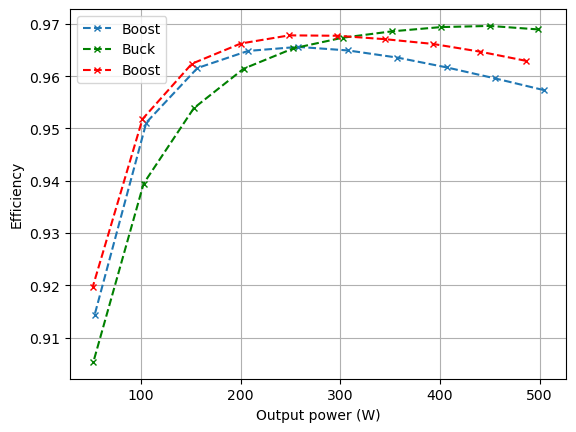

In [16]:
import matplotlib.pyplot as plt
# create a figure and axis object
fig, ax = plt.subplots()

# plot Efficiency vs. Pout for bucky dataframe
# ax.plot(bucky['Pout'], bucky['Eff'],linestyle='--', marker='x', markersize=10, label='Buck')

# # plot Eff vs. Pout for boosty dataframe
ax.plot(boosty['Pout'], boosty['Eff'],linestyle='--', marker='x', markersize=5, label='Boost')

ax.plot(power_oldbuck, old_buck,linestyle='--', marker='x', markersize=5, label='Buck',color='green')

# plot Eff vs. Pout for boosty dataframe
ax.plot(power_oldboost, old_boost,linestyle='--', marker='x', markersize=5, label='Boost',color='red')
plt.grid(visible=None, which='major', axis='both')
# set axis labels and legend
ax.set_xlabel('Output power (W)')
ax.set_ylabel('Efficiency')
ax.legend()

# display the plot
plt.show()

In [34]:
100/67
100/22


4.545454545454546

In [30]:
C=0.47e-9
R1=1/(2*np.pi*C*1e6)
R1

338.6275384933943